In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torchtext
from torchtext import data
from Batch import MyIterator, batch_size_fn
import os
from torchtext.data import get_tokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Tokenizing a sentence
- takes in a string sentence and splits it into its tokens
- converts token list into a torch tensor

In [2]:
# use pytorch's tokenizer module to create a tokenizing function
tokenizer = get_tokenizer("basic_english")

# tokenize our senetence
tokens = tokenizer("This is a pytorch tutorial for tokenization!")

# create a numpy array to hold the token list
sentence_np = np.linspace(0,len(tokens), len(tokens), False)

# convert to torch tensor
sentence_torch = torch.tensor(sentence_np, dtype=torch.long)

print(f"\n\n our test sentence : {sentence_torch}\n\n")



 our test sentence : tensor([0, 1, 2, 3, 4, 5, 6, 7])




## Create an embedding function for our intput
- creates a embedded object of our sentence (A simple lookup table that stores embeddings of a fixed dictionary and size)
- size is vocabulary size by model dimension. 

In [57]:
class Embedder(nn.Module):
    
    def __init__(self, vocab_size, d_model):
        super().__init__()
        
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
    
    def forward(self, x):
        
        return self.embed(x)
    
# create the embedding
embed = Embedder(4000, 512)

# get embedded text
embed_text = embed(sentence_torch)

print(embed_text.shape)

torch.Size([8, 512])


## Create the Positional Encoder function
- embeds a position to each token
- incorporates a dropout functionality

In [89]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        
        print(f"shape {Variable(self.pe[:, :x.size(0)], requires_grad=False).shape}")
        
        x = x + Variable(self.pe[:, :x.size(0)], 
                         requires_grad=False)
        
        return self.dropout(x)


pos_emb = PositionalEncoder(512, 1024)

pos_emb_text = pos_emb(embed_text)

print(pos_emb_text.shape)

torch.Size([8, 512]) torch.Size([1, 8, 512])
torch.Size([1, 8, 512])


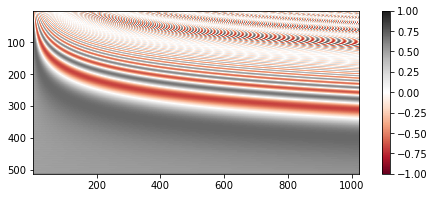

In [93]:
pe = pos_emb.pe.squeeze().T.cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)

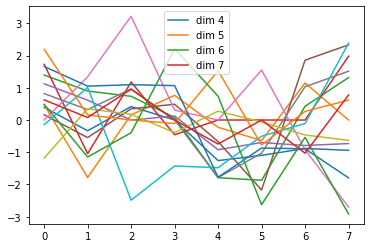

In [94]:
plt.plot(np.arange(8), pos_emb_text[0, :, 4:18].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## Scaled dot product
- create a test q, k, v (query, key, value) and caluclate the scaled dot product.
- optional mask is used to prevent current tokens from learning future ones.

In [95]:
def scaled_dot_product(
    
    q: torch.tensor, 
    k: torch.tensor, 
    v: torch.tensor, 
    mask: torch.tensor=None

) -> (torch.tensor, torch.tensor):
    
    # dimension of k 
    dimension_k = q.size()[-1]
    
    # attention logits calculated
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    
    # normalized logits
    attn_logits = attn_logits / np.sqrt(dimension_k)
    
    # check if masking is needed
    if mask is not None:
        
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    
    # calculate the attention
    attention = F.softmax(attn_logits, dim=-1)
    
    # multiply by the value matrix
    values = torch.matmul(attention, v)
    
    return values, attention

# ===================================================================

# test with random tensors

#
seq_len, d_k = 8, 512

# initiate q, k, v
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

# calculate the attention and values
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)
print("Values\n", values.shape)
print("Attention\n", attention.shape)


Q
 torch.Size([8, 512])
K
 torch.Size([8, 512])
V
 torch.Size([8, 512])
Values
 torch.Size([8, 512])
Attention
 torch.Size([8, 8])


## Multihead attention

In [97]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim: int, dim_model: int, num_heads: int):
        
        super().__init__()
        
        assert dim_model % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        # set the embedind dimension
        self.embed_dim = dim_model
        self.num_heads = num_heads
        self.head_dim = dim_model // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*dim_model)
        self.o_proj = nn.Linear(dim_model, dim_model)

        self._reset_parameters()

    def _reset_parameters(self):
        
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(
        
        self, 
        x: torch.tensor, 
        mask: torch.tensor=None
    
    ) -> (torch.tensor, torch.tensor):
        
        # extract dimensions of the embedding x
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o, attention
        
# ===================================================================

# test with random tensors

#

mha = MultiheadAttention(512, dim_model=512, num_heads=8)
sample_sentence = torch.randn(8, 8, 512)
output, attn = mha(pos_emb_text)

print("mha output\n", output.shape)
print("Attention\n", attn.shape)

mha output
 torch.Size([1, 8, 512])
Attention
 torch.Size([1, 8, 8, 8])


In [ ]:
print(output.shape)